In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.morphology import remove_small_objects
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
import nibabel as nib
import scipy.stats
from scipy.stats import mannwhitneyu, ttest_ind, ranksums, ttest_rel
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.stats import norm
from scipy.stats import wilcoxon
from scipy.stats import ranksums

from scipy.stats import t

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg

np.random.seed(42)

In [5]:
def dice_score_per_intensity(array1, array2, intensity_list):
     
    dice_scores = []

    for intensity in intensity_list:
        mask1 = array1 == intensity
        
        # for some reason the GS segmentations are in LR flipped form to the unet outputs
        # just flipping back here...
        if 1000 < intensity < 2000:
            mask2 = array2 == intensity + 1000
        else:
            mask2 = array2 == intensity - 1000

        intersection = np.sum(mask1 & mask2)  
        sum_mask1 = np.sum(mask1)
        sum_mask2 = np.sum(mask2)

        # Dice per intensity
        if sum_mask1 + sum_mask2 == 0:  # no intensities present in either. Just set to 0
            dice_score = 0.0
        else:
            dice_score = (2. * intersection)/(sum_mask1 + sum_mask2) 

        dice_scores.append(dice_score)
        
    return np.array(dice_scores)


def hd_score_per_intensity(array1, array2, intensity_list):

    hd_scores = []
    for intensity in intensity_list:

        mask1 = array1 == intensity
        
        ## same deal as for the above dice function
        if 1000 < intensity < 2000:
            mask2 = array2 == intensity + 1000
        else:
            mask2 = array2 == intensity - 1000
            
        sum_mask1 = np.sum(mask1)
        sum_mask2 = np.sum(mask2)

        # Calculate average HD. 
        if sum_mask2 == 0:    #HD would be infinite if a segmentation is missing...
            hd_scores.append(None)
        else:
            hd_score = average_hausdorff_distance(mask1, mask2)
            hd_scores.append(hd_score)

    return np.array(hd_scores)



def compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path):
    dice_array = np.zeros((len(case_list),len(intensity_list)))

    counter = 0
    for case in case_list:
        print("starting case: ", case)
        dir_case = os.path.join(basepath,case)

        seg_vol_gt = nib.load(os.path.join(dir_case,seg_gt_path))
        seg_vol_gt_np = seg_vol_gt.get_fdata()

        seg_vol_unet = nib.load(os.path.join(dir_case,seg_unet_path))
        seg_vol_unet_np = seg_vol_unet.get_fdata()
        
        ## remove small stray segs which aren't connected (<10 voxels) 
        for intensity in intensity_list:
            mask = seg_vol_unet_np == intensity
            cleaned_mask = remove_small_objects(mask, min_size=10,connectivity=2)
            seg_vol_unet_np[mask & ~cleaned_mask] = 0  # Set the small objects to 0
        
        

        dice_out = dice_score_per_intensity(seg_vol_gt_np, seg_vol_unet_np, BSB_intensity_list)
        dice_array[counter,:] = dice_out
        counter += 1
        
    return dice_array


def compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path):
    hd_array = np.zeros((len(case_list),len(intensity_list)))

    counter = 0
    for case in case_list:
        print("case is: ", case)
        dir_case = os.path.join(basepath,case)

        seg_vol_gt = nib.load(os.path.join(dir_case,seg_gt_path))
        seg_vol_gt_np = seg_vol_gt.get_fdata()

        seg_vol_unet = nib.load(os.path.join(dir_case,seg_unet_path))
        seg_vol_unet_np = seg_vol_unet.get_fdata()
        
        ## remove small stray segs which aren't connected (<10 voxels) 
        for intensity in intensity_list:
            mask = seg_vol_unet_np == intensity
            cleaned_mask = remove_small_objects(mask, min_size=10,connectivity=2)
            seg_vol_unet_np[mask & ~cleaned_mask] = 0  # Set the small objects to 0

        hd_out = hd_score_per_intensity(seg_vol_gt_np, seg_vol_unet_np, BSB_intensity_list)
        if np.any(hd_out == None):
            hd_array[counter,:] = hd_out
            counter +=1
        else:
            hd_array[counter,:] = hd_out
            counter += 1
    return hd_array



def average_hausdorff_distance(array1, array2):
    coords1 = np.argwhere(array1)
    coords2 = np.argwhere(array2)

    # Calculate the directed Hausdorff distances from array1 to array2 and vice versa
    dist1 = directed_hausdorff(coords1, coords2, seed=None)[0]
    dist2 = directed_hausdorff(coords2, coords1, seed=None)[0]

    # Calculate average hausdorff dist
    hausdorff_dist = (dist1 + dist2)/2

    return hausdorff_dist


def calculate_p_values(cluster,alt='two-sided'):
    p_values = []
    for i in range(1, len(cluster)):
        stat, p_value = wilcoxon(cluster[0], cluster[i],alternative=alt)
        p_values.append(p_value)
    return p_values


def create_dataframe(mean_coeff_bsb, mean_coeff_nocrf, mean_coeff_noattention, mean_coeff_v1, mean_coeff_norgb,score_type="Dice"):
    subjects = np.repeat(np.arange(1, mean_coeff_bsb.shape[0] + 1), 5)
    cnn_types = np.tile(['BSBT', 'Ablated_CRF CNN', 'Ablated_Attention CNN', 'PFM V1 CNN', 'Ablated_PFM CNN'], mean_coeff_bsb.shape[0])
    scores = [item for pair in zip(mean_coeff_bsb, mean_coeff_nocrf, mean_coeff_noattention, mean_coeff_v1, mean_coeff_norgb) for item in pair]
    if score_type == "Dice":
        data = {
            'Subject': subjects,
            'CNN': cnn_types,
            'DiceScore': scores
        }
    else:
        data = {
            'Subject': subjects,
            'CNN': cnn_types,
            'HDScore': scores
        }
    return pd.DataFrame(data)



def calculate_z_pvalues_mixedlm(model):
    # model.params and model.bse are Series indexed by parameter names
    z_stats = model.params / model.bse          # As used in MixedLM summary
    p_values = 2 * (1 - norm.cdf(np.abs(z_stats)))
    return z_stats, p_values


def combine_stats_pvalues(t_stats, p_values):
    combined = pd.DataFrame({
        't-statistics': t_stats,
        'p-values': p_values
    })
    return combined


In [6]:
case_list_basepath = "/Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS"
case_list_GT_basepath = "/Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID"


case_list_HCP_validation_ORIG = ["subject_101107",
                                "subject_103414",
                                "subject_105115",
                                "subject_110411",
                                "subject_208226",
                                "subject_113619",
                                "subject_116524",
                                "subject_124422",
                                "subject_131722",
                                "subject_133019",
                                "subject_133928",
                                "subject_135225",
                                "subject_136833",
                                "subject_140925",
                                "subject_144832"]

case_list_EXC = ["subject_C1_rotated",
                "subject_C2",
                "subject_C4",
                "subject_EXC007",
                "subject_EXC012",
                "subject_EXC020",
                "subject_EXC021"]

case_list_ADNI = ["subject_002_S_4213",
                  "subject_002_S_4225",
                  "subject_002_S_6009",
                  "subject_002_S_6030",
                  "subject_002_S_6053",
                  "subject_003_S_6259",
                  "subject_003_S_6260",
                  "subject_003_S_6307",
                  "subject_012_S_4643",
                  "subject_016_S_4951"]



BSB_intensity_list = [1001,2001,1002,2002,1003,2003,1004,2004,1005,2005,1006,2006,1007,2007,1008,2008]
BSB_intensity_list_L = [1001,1002,1003,1004,1005,1006,1007,1008]
BSB_intensity_list_R = [2001,2002,2003,2004,2005,2006,2007,2008]



label_names = ["left MLc", 
               "right MLc",
               "left SCP",
               "right SCP",
               "left LFB",
               "right LFB",
               "left MHB",
               "right MHB",
               "left Bic",
               "right Bic",
               "left MLr",
               "right MLr",
               "left MLF",
               "right MLF",
               "left CTG",
               "right CTG"]

label_names_nolr = ["MLc", 
                   "SCP",
                   "MFB",
                   "MHB",
                   "Bic",
                   "MLr",
                   "MLF",
                   "CTG"]

In [7]:
### FOR HCP Validation ###

dice_array_hcp = np.zeros((len(case_list_HCP_validation_ORIG),len(BSB_intensity_list)))

counter = 0
for case in case_list_HCP_validation_ORIG:
    dir_case_input = os.path.join(case_list_GT_basepath,case)
    dir_case_output = os.path.join(case_list_basepath,case)
    ## conform to same shape as unet output
    os.system("mri_convert " + os.path.join(dir_case_input,"segs","all_aan_manual_anno.nii.gz") + " " + os.path.join(dir_case_output,"segs","seg_conformed.nii.gz") + " -rl " + os.path.join(dir_case_output,"results_bsb_rawres","bsNet.crfseg.mgz") + " -rt nearest -odt float")
    

print("\n\n starting raw \n\n") 
case_list = case_list_HCP_validation_ORIG
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.crfseg.mgz")

dice_array_hcp = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_hcp = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n starting ablated CRF \n\n")
case_list = case_list_HCP_validation_ORIG
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.seg.mgz")

dice_array_hcp_nocrf = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_hcp_nocrf = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)


print("\n\n starting ablated attention \n\n")
case_list = case_list_HCP_validation_ORIG
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_noattention","bsNet.crfseg.mgz")

dice_array_hcp_noattention = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_hcp_noattention = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n starting ablated SIM channel \n\n")
case_list = case_list_HCP_validation_ORIG
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_norgb","bsNet.crfseg.mgz")

dice_array_hcp_norgb = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_hcp_norgb = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)


print("\n\n starting v1 channel \n\n")
case_list = case_list_HCP_validation_ORIG
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_v1","bsNet.crfseg.mgz")

dice_array_hcp_v1 = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_hcp_v1 = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_101107/segs/all_aan_manual_anno.nii.gz /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_101107/segs/seg_conformed.nii.gz -rl /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_101107/results_bsb_rawres/bsNet.crfseg.mgz -rt nearest -odt float 
reading from /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_101107/segs/all_aan_manual_anno.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
reading template info from volume /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_101107/results_bsb_rawres/bsNet.crfseg.mgz...
Reslicing using nearest 
writing to /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_101107/segs/seg_conformed.nii.gz...
mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_103414/segs/all_aan_manual_anno.

reading from /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_133019/segs/all_aan_manual_anno.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
reading template info from volume /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_133019/results_bsb_rawres/bsNet.crfseg.mgz...
Reslicing using nearest 
writing to /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_133019/segs/seg_conformed.nii.gz...
mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_133928/segs/all_aan_manual_anno.nii.gz /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_133928/segs/seg_conformed.nii.gz -rl /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_133928/results_bsb_rawres/bsNet.crfseg.mgz -rt nearest -odt float 
reading from /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_133928/segs/all_aan_manual_anno

case is:  subject_133019
case is:  subject_133928
case is:  subject_135225
case is:  subject_136833
case is:  subject_140925
case is:  subject_144832


 starting v1 channel 


starting case:  subject_101107
starting case:  subject_103414
starting case:  subject_105115
starting case:  subject_110411
starting case:  subject_208226
starting case:  subject_113619
starting case:  subject_116524
starting case:  subject_124422
starting case:  subject_131722
starting case:  subject_133019
starting case:  subject_133928
starting case:  subject_135225
starting case:  subject_136833
starting case:  subject_140925
starting case:  subject_144832
case is:  subject_101107
case is:  subject_103414
case is:  subject_105115
case is:  subject_110411
case is:  subject_208226
case is:  subject_113619
case is:  subject_116524
case is:  subject_124422
case is:  subject_131722
case is:  subject_133019
case is:  subject_133928
case is:  subject_135225
case is:  subject_136833
case is:  subject_140925
case is: 

In [15]:
## calculate mean Dice scores ##
mean_dice_bsb = np.mean(dice_array_hcp,axis=1)
mean_dice_nocrf = np.mean(dice_array_hcp_nocrf,axis=1)
mean_dice_noattention = np.mean(dice_array_hcp_noattention,axis=1)
mean_dice_norgb = np.mean(dice_array_hcp_norgb,axis=1)
mean_dice_v1 = np.mean(dice_array_hcp_v1,axis=1)


## calculate mean Dice scores ##
mean_dice_bsb_scalar_hcp = np.mean(dice_array_hcp)
mean_dice_nocrf_scalar_hcp = np.mean(dice_array_hcp_nocrf)
mean_dice_noattention_scalar_hcp = np.mean(dice_array_hcp_noattention)
mean_dice_norgb_scalar_hcp = np.mean(dice_array_hcp_norgb)
mean_dice_v1_scalar_hcp = np.mean(dice_array_hcp_v1)

print("mean dice BSB: ", mean_dice_bsb_scalar_hcp)
print("mean dice no crf: ", mean_dice_nocrf_scalar_hcp)
print("mean dice no attention: ", mean_dice_noattention_scalar_hcp)
print("mean dice no rgb: ", mean_dice_norgb_scalar_hcp)
print("mean dice v1: ", mean_dice_v1_scalar_hcp)

mean dice BSB:  0.6980504982699186
mean dice no crf:  0.692663798501441
mean dice no attention:  0.6387294097464437
mean dice no rgb:  0.6521106992131015
mean dice v1:  0.6698366433609176


In [17]:
## calculate mean HD scores ##
mean_hd_bsb = np.mean(hd_array_hcp,axis=1)
mean_hd_nocrf = np.mean(hd_array_hcp_nocrf,axis=1)
mean_hd_noattention = np.mean(hd_array_hcp_noattention,axis=1)
mean_hd_norgb = np.mean(hd_array_hcp_norgb,axis=1)
mean_hd_v1 = np.mean(hd_array_hcp_v1,axis=1)


## calculate mean HD scores ##
mean_hd_bsb_scalar_hcp = np.mean(hd_array_hcp)
mean_hd_nocrf_scalar_hcp = np.mean(hd_array_hcp_nocrf)
mean_hd_noattention_scalar_hcp = np.mean(hd_array_hcp_noattention)
mean_hd_norgb_scalar_hcp = np.mean(hd_array_hcp_norgb)
mean_hd_v1_scalar_hcp = np.mean(hd_array_hcp_v1)

print("mean HD BSB: ", mean_hd_bsb_scalar_hcp)
print("mean HD no crf: ", mean_hd_nocrf_scalar_hcp)
print("mean HD no attention: ", mean_hd_noattention_scalar_hcp)
print("mean HD no rgb: ", mean_hd_norgb_scalar_hcp)
print("mean HD v1: ", mean_hd_v1_scalar_hcp)

mean HD BSB:  2.107635870516828
mean HD no crf:  2.098482021480677
mean HD no attention:  2.1881714384986837
mean HD no rgb:  2.2110404019262533
mean HD v1:  2.1653911775904233


In [11]:
##########################################
########### FOR EXC ######################
#####################################


dice_array_exc = np.zeros((len(case_list_EXC),len(BSB_intensity_list)))

counter = 0
for case in case_list_EXC:
    dir_case_input = os.path.join(case_list_GT_basepath,case)
    dir_case_output = os.path.join(case_list_basepath,case)
    ## conform to same shape as unet output
    os.system("mri_convert " + os.path.join(dir_case_input,"segs","all_aan_manual_anno.nii.gz") + " " + os.path.join(dir_case_output,"segs","seg_conformed.nii.gz") + " -rl " + os.path.join(dir_case_output,"results_bsb_rawres","bsNet.crfseg.mgz") + " -rt nearest -odt float")
    
print("\n\n starting raw \n\n") 
case_list = case_list_EXC
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.crfseg.mgz")

dice_array_exc = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_exc = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n starting ablated CRF \n\n")
case_list = case_list_EXC
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.seg.mgz")

dice_array_exc_nocrf = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_exc_nocrf = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n starting ablated attention \n\n")
case_list = case_list_EXC
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_noattention","bsNet.crfseg.mgz")

dice_array_exc_noattention = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_exc_noattention = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n starting ablated SIM \n\n")
case_list = case_list_EXC
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_norgb","bsNet.crfseg.mgz")

dice_array_exc_norgb = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_exc_norgb = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n starting v1 \n\n")
case_list = case_list_EXC
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_v1","bsNet.crfseg.mgz")

dice_array_exc_v1 = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_exc_v1 = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_C1_rotated/segs/all_aan_manual_anno.nii.gz /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_C1_rotated/segs/seg_conformed.nii.gz -rl /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_C1_rotated/results_bsb_rawres/bsNet.crfseg.mgz -rt nearest -odt float 
reading from /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_C1_rotated/segs/all_aan_manual_anno.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
reading template info from volume /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_C1_rotated/results_bsb_rawres/bsNet.crfseg.mgz...
Reslicing using nearest 
writing to /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_C1_rotated/segs/seg_conformed.nii.gz...
mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_C2/segs/

In [20]:
## calculate mean Dice scores ##
mean_dice_bsb_exc = np.mean(dice_array_exc,axis=1)
mean_dice_nocrf_exc = np.mean(dice_array_exc_nocrf,axis=1)
mean_dice_noattention_exc = np.mean(dice_array_exc_noattention,axis=1)
mean_dice_norgb_exc = np.mean(dice_array_exc_norgb,axis=1)
mean_dice_v1_exc = np.mean(dice_array_exc_v1,axis=1)


## calculate mean Dice scores ##
mean_dice_bsb_scalar_exc = np.mean(dice_array_exc)
mean_dice_nocrf_scalar_exc = np.mean(dice_array_exc_nocrf)
mean_dice_noattention_scalar_exc = np.mean(dice_array_exc_noattention)
mean_dice_norgb_scalar_exc = np.mean(dice_array_exc_norgb)
mean_dice_v1_scalar_exc = np.mean(dice_array_exc_v1)

print("mean dice BSB: ", mean_dice_bsb_scalar_exc)
print("mean dice no crf: ", mean_dice_nocrf_scalar_exc)
print("mean dice no attention: ", mean_dice_noattention_scalar_exc)
print("mean dice no rgb: ", mean_dice_norgb_scalar_exc)
print("mean dice v1: ", mean_dice_v1_scalar_exc)

mean dice BSB:  0.6153412043696177
mean dice no crf:  0.5899623705836703
mean dice no attention:  0.4768447597767257
mean dice no rgb:  0.467060796140931
mean dice v1:  0.5105900421601851


In [21]:
## calculate mean HD scores ##
mean_hd_bsb_exc = np.nanmean(hd_array_exc,axis=1)
mean_hd_nocrf_exc = np.nanmean(hd_array_exc_nocrf,axis=1)
mean_hd_noattention_exc = np.nanmean(hd_array_exc_noattention,axis=1)
mean_hd_norgb_exc = np.nanmean(hd_array_exc_norgb,axis=1)
mean_hd_v1_exc = np.nanmean(hd_array_exc_v1,axis=1)


## calculate mean HD scores ##
mean_hd_bsb_scalar_exc = np.nanmean(hd_array_exc)
mean_hd_nocrf_scalar_exc = np.nanmean(hd_array_exc_nocrf)
mean_hd_noattention_scalar_exc = np.nanmean(hd_array_exc_noattention)
mean_hd_norgb_scalar_exc = np.nanmean(hd_array_exc_norgb)
mean_hd_v1_scalar_exc = np.nanmean(hd_array_exc_v1)

print("mean HD BSB: ", mean_hd_bsb_scalar_exc)
print("mean HD no crf: ", mean_hd_nocrf_scalar_exc)
print("mean HD no attention: ", mean_hd_noattention_scalar_exc)
print("mean HD no rgb: ", mean_hd_norgb_scalar_exc)
print("mean HD v1: ", mean_hd_v1_scalar_exc)

mean HD BSB:  2.322478979597072
mean HD no crf:  2.271268136842504
mean HD no attention:  2.5177343870919886
mean HD no rgb:  2.9117673141466223
mean HD v1:  2.735346176387801


In [22]:
##########################################
########### FOR ADNI ######################



dice_array_ADNI = np.zeros((len(case_list_ADNI),len(BSB_intensity_list)))

counter = 0
for case in case_list_ADNI:
    dir_case_input = os.path.join(case_list_GT_basepath,case)
    dir_case_output = os.path.join(case_list_basepath,case)
    ## conform to same shape as unet output
    os.system("mri_convert " + os.path.join(dir_case_input,"segs","all_aan_manual_anno.nii.gz") + " " + os.path.join(dir_case_output,"segs","seg_conformed.nii.gz") + " -rl " + os.path.join(dir_case_output,"results_bsb_rawres","bsNet.crfseg.mgz") + " -rt nearest -odt float")
    
print("\n\n starting raw \n\n") 
case_list = case_list_ADNI
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.crfseg.mgz")

dice_array_ADNI = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_ADNI = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n ablated CRF \n\n") 
case_list = case_list_ADNI
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_bsb_rawres_nativeres","bsNet.seg.mgz")

dice_array_ADNI_nocrf = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_ADNI_nocrf = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

print("\n\n ablated attention \n\n") 
case_list = case_list_ADNI
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_noattention","bsNet.crfseg.mgz")

dice_array_ADNI_noattention = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_ADNI_noattention = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)


print("\n\n V1 \n\n") 
case_list = case_list_ADNI
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_v1","bsNet.crfseg.mgz")

dice_array_ADNI_v1 = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_ADNI_v1 = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)


print("\n\n ablated SIM \n\n") 
case_list = case_list_ADNI
intensity_list = BSB_intensity_list
basepath = case_list_basepath
seg_gt_path = os.path.join("segs","seg_conformed.nii.gz")
seg_unet_path = os.path.join("results_norgb","bsNet.crfseg.mgz")

dice_array_ADNI_norgb = compute_dice_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)
hd_array_ADNI_norgb = compute_hd_for_cases(case_list,intensity_list,basepath,seg_gt_path,seg_unet_path)

mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_002_S_4213/segs/all_aan_manual_anno.nii.gz /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_002_S_4213/segs/seg_conformed.nii.gz -rl /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_002_S_4213/results_bsb_rawres/bsNet.crfseg.mgz -rt nearest -odt float 
reading from /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_002_S_4213/segs/all_aan_manual_anno.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, -0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
reading template info from volume /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_002_S_4213/results_bsb_rawres/bsNet.crfseg.mgz...
Reslicing using nearest 
writing to /Users/markolchanyi/Desktop/BSB_validation/ALL_SUBJECTS/subject_002_S_4213/segs/seg_conformed.nii.gz...
mri_convert /Users/markolchanyi/Desktop/BSB_validation/ALL_MANUAL_ANNOTATIONS_VALID/subject_002_S

starting case:  subject_002_S_4225
starting case:  subject_002_S_6009
starting case:  subject_002_S_6030
starting case:  subject_002_S_6053
starting case:  subject_003_S_6259
starting case:  subject_003_S_6260
starting case:  subject_003_S_6307
starting case:  subject_012_S_4643
starting case:  subject_016_S_4951
case is:  subject_002_S_4213
case is:  subject_002_S_4225
case is:  subject_002_S_6009
case is:  subject_002_S_6030
case is:  subject_002_S_6053
case is:  subject_003_S_6259
case is:  subject_003_S_6260
case is:  subject_003_S_6307
case is:  subject_012_S_4643
case is:  subject_016_S_4951


 ablated CRF 


starting case:  subject_002_S_4213
starting case:  subject_002_S_4225
starting case:  subject_002_S_6009
starting case:  subject_002_S_6030
starting case:  subject_002_S_6053
starting case:  subject_003_S_6259
starting case:  subject_003_S_6260
starting case:  subject_003_S_6307
starting case:  subject_012_S_4643
starting case:  subject_016_S_4951
case is:  subject_002_S_421

In [23]:
## calculate mean Dice scores ##
mean_dice_bsb_ADNI = np.mean(dice_array_ADNI,axis=1)
mean_dice_nocrf_ADNI = np.mean(dice_array_ADNI_nocrf,axis=1)
mean_dice_noattention_ADNI = np.mean(dice_array_ADNI_noattention,axis=1)
mean_dice_norgb_ADNI = np.mean(dice_array_ADNI_norgb,axis=1)
mean_dice_v1_ADNI = np.mean(dice_array_ADNI_v1,axis=1)

## calculate mean Dice scores ##
mean_dice_bsb_scalar_ADNI = np.mean(dice_array_ADNI)
mean_dice_nocrf_scalar_ADNI = np.mean(dice_array_ADNI_nocrf)
mean_dice_noattention_scalar_ADNI = np.mean(dice_array_ADNI_noattention)
mean_dice_norgb_scalar_ADNI = np.mean(dice_array_ADNI_norgb)
mean_dice_v1_scalar_ADNI = np.mean(dice_array_ADNI_v1)

print("mean dice BSB: ", mean_dice_bsb_scalar_ADNI)
print("mean dice no crf: ", mean_dice_nocrf_scalar_ADNI)
print("mean dice no attention: ", mean_dice_noattention_scalar_ADNI)
print("mean dice no rgb: ", mean_dice_norgb_scalar_ADNI)
print("mean dice no v1: ", mean_dice_v1_scalar_ADNI)

mean dice BSB:  0.6643622600076888
mean dice no crf:  0.6413367883465692
mean dice no attention:  0.6189559718580776
mean dice no rgb:  0.6024011415926361
mean dice no v1:  0.6025700027950384


In [24]:
## calculate mean HD scores ##
mean_hd_bsb_ADNI = np.nanmean(hd_array_ADNI,axis=1)
mean_hd_nocrf_ADNI = np.nanmean(hd_array_ADNI_nocrf,axis=1)
mean_hd_noattention_ADNI = np.nanmean(hd_array_ADNI_noattention,axis=1)
mean_hd_norgb_ADNI = np.nanmean(hd_array_ADNI_norgb,axis=1)
mean_hd_v1_ADNI = np.nanmean(hd_array_ADNI_v1,axis=1)

## calculate mean HD scores ##
mean_hd_bsb_scalar_ADNI = np.nanmean(hd_array_ADNI)
mean_hd_nocrf_scalar_ADNI = np.nanmean(hd_array_ADNI_nocrf)
mean_hd_noattention_scalar_ADNI = np.nanmean(hd_array_ADNI_noattention)
mean_hd_v1_scalar_ADNI = np.nanmean(hd_array_ADNI_v1)
mean_hd_norgb_scalar_ADNI = np.nanmean(hd_array_ADNI_norgb)

print("mean HD BSB: ", mean_hd_bsb_scalar_ADNI)
print("mean HD no crf: ", mean_hd_nocrf_scalar_ADNI)
print("mean HD no attention: ", mean_hd_noattention_scalar_ADNI)
print("mean HD no rgb: ", mean_hd_norgb_scalar_ADNI)
print("mean HD v1: ", mean_hd_v1_scalar_ADNI)

mean HD BSB:  2.3355913735775387
mean HD no crf:  2.3662302356956766
mean HD no attention:  2.338098572647974
mean HD no rgb:  2.4719256426906413
mean HD v1:  2.4174060467695595


/Users/markolchanyi/opt/anaconda3/envs/bsb_stats_eval/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/markolchanyi/opt/anaconda3/envs/bsb_stats_eval/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/markolchanyi/opt/anaconda3/envs/bsb_stats_eval/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


HCP Model z-statistics and p-values:
                              t-statistics   p-values
Intercept                      64.15604893 0.00000000
CNN[T.Ablated_CRF CNN]         -0.81434817 0.41544552
CNN[T.Ablated_Attention CNN]   -8.96801793 0.00000000
CNN[T.PFM V1 CNN]              -4.26530199 0.00001996
CNN[T.Ablated_PFM CNN]         -6.94506712 0.00000000
Group Var                       2.26390224 0.02358013

Ex Vivo Model z-statistics and p-values:
                              t-statistics   p-values
Intercept                      30.45322782 0.00000000
CNN[T.Ablated_CRF CNN]         -1.76384890 0.07775742
CNN[T.Ablated_Attention CNN]   -9.62561181 0.00000000
CNN[T.PFM V1 CNN]              -7.28028814 0.00000000
CNN[T.Ablated_PFM CNN]        -10.30560497 0.00000000
Group Var                       1.45065633 0.14687558

ADNI Model z-statistics and p-values:
                              t-statistics   p-values
Intercept                      65.58611114 0.00000000
CNN[T.Ablated_CRF 

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_14736/2712223420.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


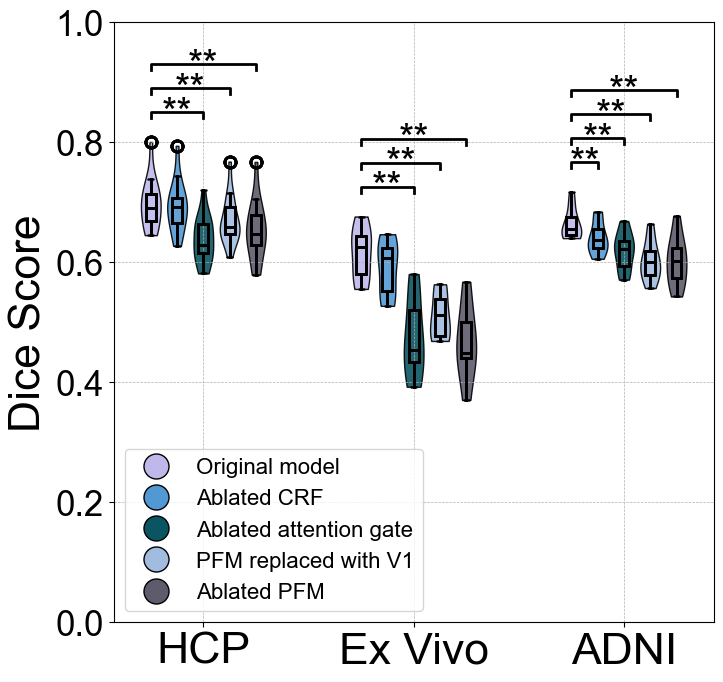

In [33]:
###################### REDONE WITH LINEAR MIXED EFFECTS MODEL AS PER RECOMMENDATION ########################


plt.rcParams['font.family'] = 'Arial'

pd.options.display.float_format = '{:.8f}'.format

# Calculate all WMB averages for each subject
mean_dice_bsb = np.mean(dice_array_hcp, axis=1)
mean_dice_nocrf = np.mean(dice_array_hcp_nocrf, axis=1)
mean_dice_noattention = np.mean(dice_array_hcp_noattention, axis=1)
mean_dice_norgb = np.mean(dice_array_hcp_norgb, axis=1)
mean_dice_v1 = np.mean(dice_array_hcp_v1, axis=1)

mean_dice_bsb_exc = np.mean(dice_array_exc, axis=1)
mean_dice_nocrf_exc = np.mean(dice_array_exc_nocrf, axis=1)
mean_dice_noattention_exc = np.mean(dice_array_exc_noattention, axis=1)
mean_dice_norgb_exc = np.mean(dice_array_exc_norgb, axis=1)
mean_dice_v1_exc = np.mean(dice_array_exc_v1, axis=1)

mean_dice_bsb_ADNI = np.mean(dice_array_ADNI, axis=1)
mean_dice_nocrf_ADNI = np.mean(dice_array_ADNI_nocrf, axis=1)
mean_dice_noattention_ADNI = np.mean(dice_array_ADNI_noattention, axis=1)
mean_dice_norgb_ADNI = np.mean(dice_array_ADNI_norgb, axis=1)
mean_dice_v1_ADNI = np.mean(dice_array_ADNI_v1, axis=1)


df_hcp = create_dataframe(mean_dice_bsb, mean_dice_nocrf, mean_dice_noattention, mean_dice_v1, mean_dice_norgb, score_type="Dice")
df_exc = create_dataframe(mean_dice_bsb_exc, mean_dice_nocrf_exc, mean_dice_noattention_exc, mean_dice_v1_exc, mean_dice_norgb_exc, score_type="Dice")
df_adni = create_dataframe(mean_dice_bsb_ADNI, mean_dice_nocrf_ADNI, mean_dice_noattention_ADNI, mean_dice_v1_ADNI, mean_dice_norgb_ADNI, score_type="Dice")


# Ensure 'BSB' is the reference category (i.e., first catagory is automatically the reference)
for df in [df_hcp, df_exc, df_adni]:
    df['CNN'] = pd.Categorical(df['CNN'], categories=['BSBT', 'Ablated_CRF CNN', 'Ablated_Attention CNN', 'PFM V1 CNN', 'Ablated_PFM CNN'])

# Fit the linear mixed-effects model for each dataset with only a random intercept
model_hcp = mixedlm("DiceScore ~ CNN", df_hcp, groups=df_hcp["Subject"], re_formula="~1").fit()
model_exc = mixedlm("DiceScore ~ CNN", df_exc, groups=df_exc["Subject"], re_formula="~1").fit()
model_adni = mixedlm("DiceScore ~ CNN", df_adni, groups=df_adni["Subject"], re_formula="~1").fit()


hcp_z_stats, hcp_p_values = calculate_z_pvalues_mixedlm(model_hcp)
exc_z_stats, exc_p_values = calculate_z_pvalues_mixedlm(model_exc)
adni_z_stats, adni_p_values = calculate_z_pvalues_mixedlm(model_adni)


hcp_combined = combine_stats_pvalues(hcp_z_stats, hcp_p_values)
exc_combined = combine_stats_pvalues(exc_z_stats, exc_p_values)
adni_combined = combine_stats_pvalues(adni_z_stats, adni_p_values)

# Print the combined DataFrame for each dataset
print("HCP Model z-statistics and p-values:")
print(hcp_combined)
print("\nEx Vivo Model z-statistics and p-values:")
print(exc_combined)
print("\nADNI Model z-statistics and p-values:")
print(adni_combined)

print(" ")

pd.options.display.float_format = '{:.8f}'.format

print("HCP Model Summary:")
print(model_hcp.summary())
print("\nEx Vivo Model Summary:")
print(model_exc.summary())
print("\nADNI Model Summary:")
print(model_adni.summary())



print("\n p-values (HCP):", hcp_p_values)
print("p-values (Ex Vivo):", exc_p_values)
print("p-values (ADNI):", adni_p_values)

spacing_between_clusters = 40
cluster_width = 24
starting_position = 20  # Starting position for the first cluster

colors = ['#BEB8EB', '#5299D3', '#0B5563', '#A2BCE0', '#5E5C6C'] # for violin

fig = plt.figure(figsize=(10, 10))
plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

# Iterate over datasets
datasets = [df_hcp, df_exc, df_adni]
pvalues_list = [hcp_p_values, exc_p_values, adni_p_values]
cluster_positions = []

dataset_names = ['HCP', "Ex Vivo", 'ADNI']

for dataset_idx, (dataset, pvalues) in enumerate(zip(datasets, pvalues_list)):
    cluster_start = starting_position + (dataset_idx * (cluster_width + spacing_between_clusters))
    positions = [cluster_start + i * 8 for i in range(5)]
    

    vp = plt.violinplot([dataset[dataset['CNN'] == cnn]['DiceScore'] for cnn in dataset['CNN'].unique()], positions=positions, widths=6, showextrema=False, showmeans=False)

    # Color the violins/scatterrs
    for i, body in enumerate(vp['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')
        body.set_alpha(0.9)
        
        medianprops = dict(linestyle='-', linewidth=2, color='black')
        boxprops = dict(linestyle='-', linewidth=2, color='black')
        flierprops = dict(marker='o', markerfacecolor='none', markersize=8, linestyle='none', markeredgecolor='black', markeredgewidth=2)
        whiskerprops = dict(linewidth=2)
        plt.boxplot([dataset[dataset['CNN'] == cnn]['DiceScore'] for cnn in dataset['CNN'].unique()], positions=positions, widths=3, flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops, boxprops=boxprops)

    cluster_positions.append(np.mean(positions))
    
    # Significance  
    counter = 0
    print("p value is: ", pvalues[i])
    for i in range(1, 5):
        if 0.01 < pvalues[i] < 0.05:
            text = '*'
            counter += 1
        elif pvalues[i] <= 0.01:
            text = '**'
            counter += 1
        else:
            continue 
        x1, x2 = positions[0], positions[i]
        y, h, col = max(map(max, [dataset[dataset['CNN'] == cnn]['DiceScore'] for cnn in dataset['CNN'].unique()])) + counter/25, 0.01, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)  # Plotting bracket line
        plt.text((x1 + x2) * .5, y - 0.023, text, ha='center', va='bottom', color=col, fontsize=28)  # Plotting asterisk(s)

# Set x-ticks to middle of each cluster
plt.xticks(cluster_positions, ['HCP', 'Ex Vivo', 'ADNI'], fontsize=32)
plt.ylabel('Dice Score', fontsize=32)
plt.ylim([0.0, 1.0])
plt.yticks(fontsize=25, fontweight='regular')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
patch1 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#BEB8EB", label='Original model')
patch2 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#5299D3", label='Ablated CRF')
patch3 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#0B5563", label='Ablated attention gate')
patch4 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#A2BCE0", label='PFM replaced with V1')
patch5 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#5E5C6C", label='Ablated PFM')
plt.legend(loc='lower left', handles=[patch1, patch2, patch3, patch4, patch5], fontsize=22, prop={'size': 16, 'weight': 'regular'})

ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/DICE_ALL.png', dpi=300, transparent=True)
plt.show()


HCP Model t-statistics and p-values:
                              t-statistics   p-values
Intercept                      36.25065752 0.00000000
CNN[T.Ablated_CRF CNN]         -0.18178331 0.85575278
CNN[T.Ablated_Attention CNN]    1.59932963 0.10974738
CNN[T.PFM V1 CNN]               1.14694384 0.25140483
CNN[T.Ablated_PFM CNN]          2.05347693 0.04002635
Group Var                       2.11295152 0.03460492

Ex Vivo Model t-statistics and p-values:
                              t-statistics   p-values
Intercept                      17.70764838 0.00000000
CNN[T.Ablated_CRF CNN]         -0.50374265 0.61444223
CNN[T.Ablated_Attention CNN]    1.97746531 0.04798906
CNN[T.PFM V1 CNN]               4.06122621 0.00004882
CNN[T.Ablated_PFM CNN]          5.80557643 0.00000001
Group Var                       1.42670303 0.15366551

ADNI Model t-statistics and p-values:
                              t-statistics   p-values
Intercept                      23.65074720 0.00000000
CNN[T.Ablated_CRF 

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_14736/1931108173.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


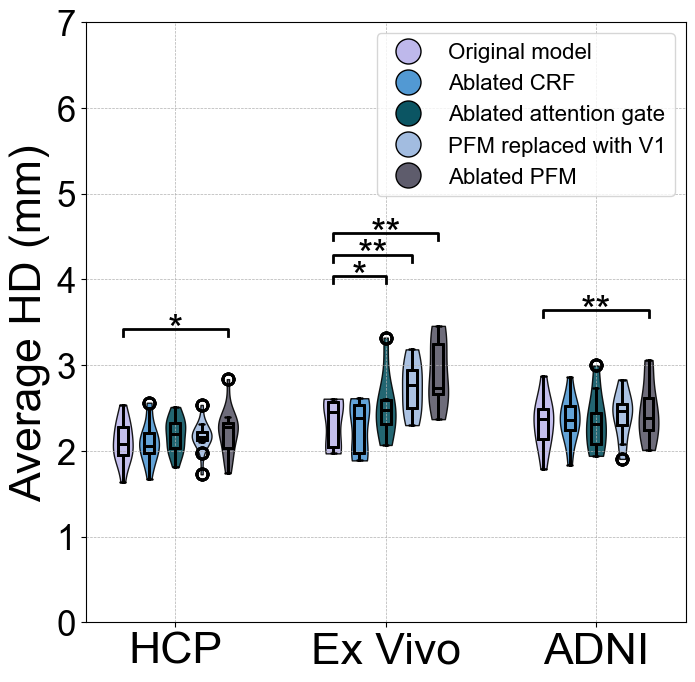

In [26]:
plt.rcParams['font.family'] = 'Arial'

# Calculate all HD averages for each subject
mean_hd_bsb = np.mean(hd_array_hcp, axis=1)
mean_hd_nocrf = np.mean(hd_array_hcp_nocrf, axis=1)
mean_hd_noattention = np.mean(hd_array_hcp_noattention, axis=1)
mean_hd_norgb = np.mean(hd_array_hcp_norgb, axis=1)
mean_hd_v1 = np.mean(hd_array_hcp_v1, axis=1)

mean_hd_bsb_exc = np.nanmean(hd_array_exc, axis=1)
mean_hd_nocrf_exc = np.nanmean(hd_array_exc_nocrf, axis=1)
mean_hd_noattention_exc = np.nanmean(hd_array_exc_noattention, axis=1)
mean_hd_norgb_exc = np.nanmean(hd_array_exc_norgb, axis=1)
mean_hd_v1_exc = np.nanmean(hd_array_exc_v1, axis=1)

mean_hd_bsb_ADNI = np.nanmean(hd_array_ADNI, axis=1)
mean_hd_nocrf_ADNI = np.nanmean(hd_array_ADNI_nocrf, axis=1)
mean_hd_noattention_ADNI = np.nanmean(hd_array_ADNI_noattention, axis=1)
mean_hd_norgb_ADNI = np.nanmean(hd_array_ADNI_norgb, axis=1)
mean_hd_v1_ADNI = np.nanmean(hd_array_ADNI_v1, axis=1)



df_hcp = create_dataframe(mean_hd_bsb, mean_hd_nocrf, mean_hd_noattention, mean_hd_v1, mean_hd_norgb, score_type="HD")
df_exc = create_dataframe(mean_hd_bsb_exc, mean_hd_nocrf_exc, mean_hd_noattention_exc, mean_hd_v1_exc, mean_hd_norgb_exc, score_type="HD")
df_adni = create_dataframe(mean_hd_bsb_ADNI, mean_hd_nocrf_ADNI, mean_hd_noattention_ADNI, mean_hd_v1_ADNI, mean_hd_norgb_ADNI, score_type="HD")

# Ensure 'BSB' is the reference category (i.e., first catagory is automatically reference)
for df in [df_hcp, df_exc, df_adni]:
    df['CNN'] = pd.Categorical(df['CNN'], categories=['BSBT', 'Ablated_CRF CNN', 'Ablated_Attention CNN', 'PFM V1 CNN', 'Ablated_PFM CNN'])

# Fit linear MEM for each dataset with only random intercpt
model_hcp = mixedlm("HDScore ~ CNN", df_hcp, groups=df_hcp["Subject"], re_formula="~1").fit()
model_exc = mixedlm("HDScore ~ CNN", df_exc, groups=df_exc["Subject"], re_formula="~1").fit()
model_adni = mixedlm("HDScore ~ CNN", df_adni, groups=df_adni["Subject"], re_formula="~1").fit()


hcp_z_stats, hcp_p_values = calculate_z_pvalues_mixedlm(model_hcp)
exc_z_stats, exc_p_values = calculate_z_pvalues_mixedlm(model_exc)
adni_z_stats, adni_p_values = calculate_z_pvalues_mixedlm(model_adni)

hcp_combined = combine_stats_pvalues(hcp_z_stats, hcp_p_values)
exc_combined = combine_stats_pvalues(exc_z_stats, exc_p_values)
adni_combined = combine_stats_pvalues(adni_z_stats, adni_p_values)


print("HCP Model t-statistics and p-values:")
print(hcp_combined)
print("\nEx Vivo Model t-statistics and p-values:")
print(exc_combined)
print("\nADNI Model t-statistics and p-values:")
print(adni_combined)


print("HCP Model z-statistics and p-values:")
print("t-statistics:", hcp_z_stats)
print("p-values:", hcp_p_values)
print("\nEx Vivo Model z-statistics and p-values:")
print("t-statistics:", exc_z_stats)
print("p-values:", exc_p_values)
print("\nADNI Model z-statistics and p-values:")
print("t-statistics:", adni_z_stats)
print("p-values:", adni_p_values)

print(" ")


print("HCP Model Summary:")
print(model_hcp.summary())
print("\nEx Vivo Model Summary:")
print(model_exc.summary())
print("\nADNI Model Summary:")
print(model_adni.summary())



spacing_between_clusters = 40
cluster_width = 24
starting_position = 20 

colors = ['#BEB8EB', '#5299D3', '#0B5563', '#A2BCE0', '#5E5C6C']

fig = plt.figure(figsize=(10, 10))
plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

# Iterate over datasets
all_datasets = [df_hcp, df_exc, df_adni]
all_pvalues = [hcp_p_values, exc_p_values, adni_p_values]
cluster_positions = []

for dataset_idx, (dataset, pvalues) in enumerate(zip(all_datasets, all_pvalues)):
    cluster_start = starting_position + (dataset_idx * (cluster_width + spacing_between_clusters))
    positions = [cluster_start + i * 8 for i in range(5)]
    
    vp = plt.violinplot([dataset[dataset['CNN'] == cnn]['HDScore'] for cnn in dataset['CNN'].unique()], positions=positions, widths=6, showextrema=False, showmeans=False)

    for i, body in enumerate(vp['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')
        body.set_alpha(0.9)
        
        medianprops = dict(linestyle='-', linewidth=2, color='black')
        boxprops = dict(linestyle='-', linewidth=2, color='black')
        flierprops = dict(marker='o', markerfacecolor='none', markersize=8, linestyle='none', markeredgecolor='black', markeredgewidth=2)
        whiskerprops = dict(linewidth=2)
        plt.boxplot([dataset[dataset['CNN'] == cnn]['HDScore'] for cnn in dataset['CNN'].unique()], positions=positions, widths=3, flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops, boxprops=boxprops)

    cluster_positions.append(np.mean(positions))
    
    # Significance  
    counter = 0
    for i in range(1, 5):
        if 0.01 < pvalues[i] < 0.05:
            text = '*'
            counter += 1
        elif pvalues[i] <= 0.01:
            text = '**'
            counter += 1
        else:
            continue 
        x1, x2 = positions[0], positions[i]
        y, h, col = max(map(max, [dataset[dataset['CNN'] == cnn]['HDScore'] for cnn in dataset['CNN'].unique()])) + 0.25 + counter/4, 8/100, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
        plt.text((x1 + x2) * .5, y - 0.15, text, ha='center', va='bottom', color=col, fontsize=28)

plt.xticks(cluster_positions, ['HCP', 'Ex Vivo', 'ADNI'], fontsize=32)
plt.ylabel('Average HD (mm)', fontsize=32)
plt.ylim([0.0, 7.0])
plt.yticks(fontsize=25, fontweight='regular')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
patch1 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#BEB8EB", label='Original model')
patch2 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#5299D3", label='Ablated CRF')
patch3 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#0B5563", label='Ablated attention gate')
patch4 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#A2BCE0", label='PFM replaced with V1')
patch5 = plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=18, linestyle="", color="#5E5C6C", label='Ablated PFM')
plt.legend(loc='upper right', handles=[patch1, patch2, patch3, patch4, patch5], fontsize=16, prop={'size': 16, 'weight': 'regular'})

ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/HD_ALL.png', dpi=300, transparent=True)
plt.show()


In [27]:
############ DICE SCORES FOR TABLES ###################
mean_dice_bsb = np.mean(dice_array_hcp,axis=0)
mean_dice_bsb_exc = np.mean(dice_array_exc,axis=0)
mean_dice_bsb_ADNI = np.mean(dice_array_ADNI,axis=0)

print("HCP:")
for count, label in enumerate(label_names_nolr):
    mean_dice_HCP = (mean_dice_bsb[count*2] + mean_dice_bsb[(count*2) + 1])/2   
    print(label,": ",mean_dice_HCP.round(2))
    
print("\n EXC:")
for count, label in enumerate(label_names_nolr):
    mean_dice_EXC = (mean_dice_bsb_exc[count*2] + mean_dice_bsb_exc[(count*2) + 1])/2   
    print(label,": ",mean_dice_EXC.round(2))
    
print("\n ADNI:")
for count, label in enumerate(label_names_nolr):
    mean_dice_ADNI = (mean_dice_bsb_ADNI[count*2] + mean_dice_bsb_ADNI[(count*2) + 1])/2   
    print(label,": ",mean_dice_ADNI.round(2))
    

print("HCP mean: ", np.mean(mean_dice_bsb))
print("EXC mean: ", np.mean(mean_dice_bsb_exc))
print("ADNI mean: ", np.mean(mean_dice_bsb_ADNI))


HCP:
MLc :  0.68
SCP :  0.78
MFB :  0.74
MHB :  0.67
Bic :  0.79
MLr :  0.72
MLF :  0.6
CTG :  0.6

 EXC:
MLc :  0.61
SCP :  0.75
MFB :  0.69
MHB :  0.59
Bic :  0.69
MLr :  0.62
MLF :  0.46
CTG :  0.51

 ADNI:
MLc :  0.65
SCP :  0.76
MFB :  0.7
MHB :  0.62
Bic :  0.73
MLr :  0.68
MLF :  0.57
CTG :  0.62
HCP mean:  0.6980504982699186
EXC mean:  0.6153412043696176
ADNI mean:  0.6643622600076888


In [28]:
############ HD SCORES FOR TABLES ###################
mean_hd_bsb = np.mean(hd_array_hcp,axis=0)
mean_hd_bsb_exc = np.nanmean(hd_array_exc,axis=0)
mean_hd_bsb_ADNI = np.nanmean(hd_array_ADNI,axis=0)

print("HCP:")
for count, label in enumerate(label_names_nolr):
    mean_hd_HCP = (mean_hd_bsb[count*2] + mean_hd_bsb[(count*2) + 1])/2   
    print(label,": ",mean_hd_HCP.round(2))
    
print("\n EXC:")
for count, label in enumerate(label_names_nolr):
    mean_hd_EXC = (mean_hd_bsb_exc[count*2] + mean_hd_bsb_exc[(count*2) + 1])/2   
    print(label,": ",mean_hd_EXC.round(2))
    
print("\n ADNI:")
for count, label in enumerate(label_names_nolr):
    mean_hd_ADNI = (mean_hd_bsb_ADNI[count*2] + mean_hd_bsb_ADNI[(count*2) + 1])/2   
    print(label,": ",mean_hd_ADNI.round(2))

    
print("HCP mean: ", np.mean(mean_hd_bsb))
print("EXC mean: ", np.mean(mean_hd_bsb_exc))
print("ADNI mean: ", np.mean(mean_hd_bsb_ADNI))



HCP:
MLc :  2.41
SCP :  2.1
MFB :  1.99
MHB :  2.08
Bic :  1.94
MLr :  1.58
MLF :  2.93
CTG :  1.84

 EXC:
MLc :  2.19
SCP :  2.31
MFB :  2.06
MHB :  2.49
Bic :  2.22
MLr :  1.96
MLF :  2.98
CTG :  2.38

 ADNI:
MLc :  2.48
SCP :  2.69
MFB :  1.82
MHB :  2.99
Bic :  2.1
MLr :  1.85
MLF :  2.76
CTG :  2.0
HCP mean:  2.107635870516828
EXC mean:  2.322478979597072
ADNI mean:  2.3355913735775387


/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_14736/63601338.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


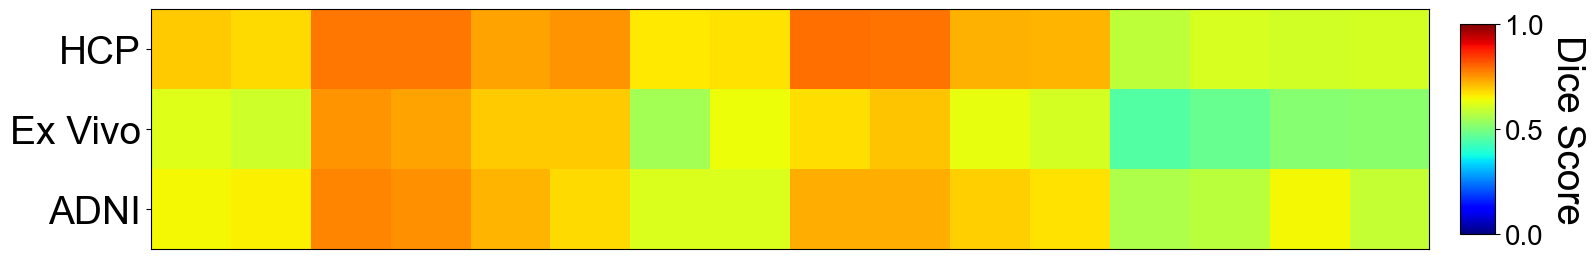

In [29]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'




data = np.array([mean_dice_bsb, mean_dice_bsb_exc, mean_dice_bsb_ADNI])


plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'



cmap = 'jet'

vmin=0
vmax=1

fig = plt.figure(figsize=(22,5)) 

plot_area = [0.3, 0.3, 0.7, 0.7] 
ax = fig.add_axes(plot_area)

plt.imshow(data, cmap=cmap, interpolation='nearest',vmin=vmin, vmax=vmax)

#cbar.formatter = formatter
#cbar.update_ticks()


cbar = plt.colorbar(shrink=0.6,aspect=6, pad=0.02)
cbar.set_label('Dice Score', rotation=270, labelpad=30, fontsize=28, fontweight='regular')
cbar.ax.tick_params(labelsize=20)


#cbar_min, cbar_max = vmin,vmax
#cbar.set_ticks([cbar_min, cbar_max])
#cbar.ax.tick_params(labelsize=28)
#for t in cbar.ax.get_yticklabels():
#    t.set_fontweight('normal')


#cbar.set_ticklabels(["0", "1"])


#plt.xticks(ticks=np.arange(len(label_names)), labels=label_names,fontsize=28,rotation=90,fontweight='regular')
#plt.xticks(ticks=np.arange(len(case_list_patient)), labels=np.arange(len(case_list_patient)),fontsize=28,fontweight='regular')
plt.yticks(ticks=[0,1,2],labels=['HCP','Ex Vivo','ADNI'], fontsize=28, fontweight='regular')
plt.xticks([])  # Hide the x-tick labels

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/DICE_heatmap.png', dpi=300, transparent=True)
plt.show()

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_14736/2171836569.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(["0.0", "1.0", "2.0", "3.0"])
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_14736/2171836569.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


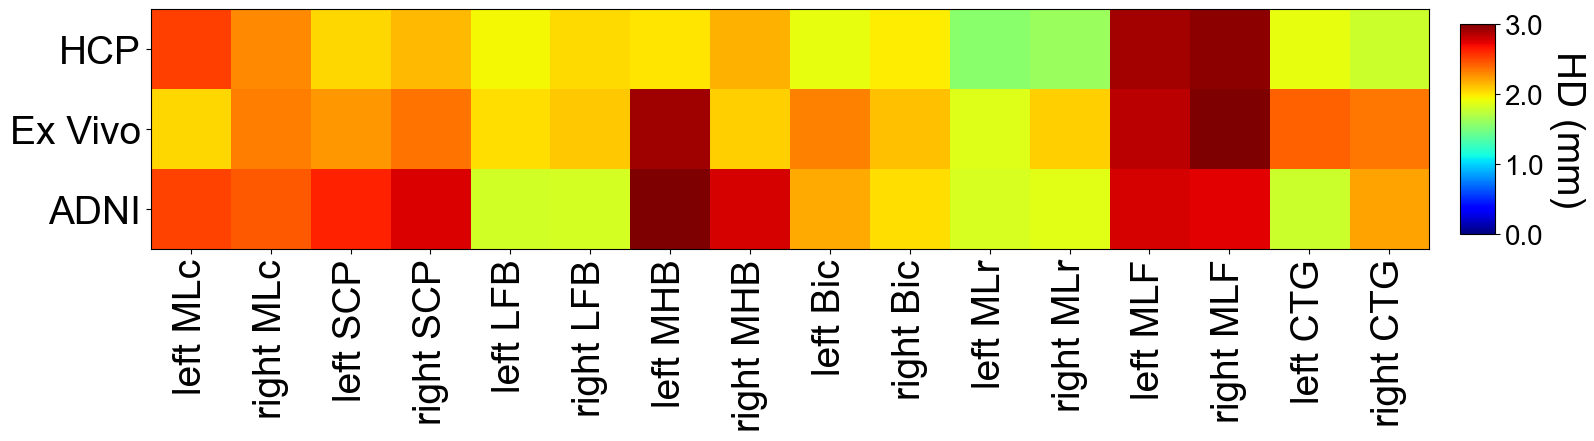

In [30]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'





data = np.array([mean_hd_bsb, mean_hd_bsb_exc, mean_hd_bsb_ADNI])



plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'



cmap = 'jet'

vmin=0
vmax=3

fig = plt.figure(figsize=(22,5))

plot_area = [0.3, 0.3, 0.7, 0.7] 
ax = fig.add_axes(plot_area)

plt.imshow(data, cmap=cmap, interpolation='nearest',vmin=vmin, vmax=vmax)

#cbar.formatter = formatter
#cbar.update_ticks()


cbar = plt.colorbar(shrink=0.6,aspect=6, pad=0.02)
cbar.set_label('HD (mm)', rotation=270, labelpad=30, fontsize=28, fontweight='regular')
cbar.ax.tick_params(labelsize=20)


#cbar_min, cbar_max = vmin,vmax
#cbar.set_ticks([cbar_min, cbar_max])
#cbar.ax.tick_params(labelsize=28)
#for t in cbar.ax.get_yticklabels():
#    t.set_fontweight('normal')


cbar.set_ticklabels(["0.0", "1.0", "2.0", "3.0"]) 


plt.xticks(ticks=np.arange(len(label_names)), labels=label_names,fontsize=28,rotation=90,fontweight='regular')
#plt.xticks(ticks=np.arange(len(case_list_patient)), labels=np.arange(len(case_list_patient)),fontsize=28,fontweight='regular')
plt.yticks(ticks=[0,1,2],labels=['HCP','Ex Vivo','ADNI'], fontsize=28, fontweight='regular')


plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/HD_heatmap.png', dpi=300, transparent=True)
plt.show()

In [31]:
### attention ablation ####
attention_diff_hcp = mean_dice_bsb_scalar_hcp - mean_dice_noattention_scalar_hcp
attention_diff_exc = mean_dice_bsb_scalar_exc - mean_dice_noattention_scalar_exc
attention_diff_ADNI = mean_dice_bsb_scalar_ADNI - mean_dice_noattention_scalar_ADNI
print(np.mean([attention_diff_hcp,attention_diff_exc,attention_diff_ADNI]))

attention_diff_hcp = mean_hd_bsb_scalar_hcp - mean_hd_noattention_scalar_hcp
attention_diff_exc = mean_hd_bsb_scalar_exc - mean_hd_noattention_scalar_exc
attention_diff_ADNI = mean_hd_bsb_scalar_ADNI - mean_hd_noattention_scalar_ADNI
print(np.mean([attention_diff_hcp,attention_diff_exc,attention_diff_ADNI]))

0.08107460708865939
-0.09276605818240242


In [32]:
### PFM ablation ####
attention_diff_hcp = mean_dice_bsb_scalar_hcp - mean_dice_norgb_scalar_hcp
attention_diff_exc = mean_dice_bsb_scalar_exc - mean_dice_norgb_scalar_exc
attention_diff_ADNI = mean_dice_bsb_scalar_ADNI - mean_dice_norgb_scalar_ADNI
print(np.mean([attention_diff_hcp,attention_diff_exc,attention_diff_ADNI]))

attention_diff_hcp = mean_hd_bsb_scalar_hcp - mean_hd_norgb_scalar_hcp
attention_diff_exc = mean_hd_bsb_scalar_exc - mean_hd_norgb_scalar_exc
attention_diff_ADNI = mean_hd_bsb_scalar_ADNI - mean_hd_norgb_scalar_ADNI
print(np.mean([attention_diff_hcp,attention_diff_exc,attention_diff_ADNI]))

0.08539377523351883
-0.2763423783573593
